# Load modules

In [2]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 214 GB / percent used: 15.0 %


# Load model data

In [3]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'

# Check the differences between ERA-Interim and model for Near-Surface Air Temperature

## Load first member

In [4]:
realization = 'r1i1p1f1'
var = 'tas'
table = 'Amon'

# Load historical
tas = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]-273.15

# ERA-Interim
tas_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/t2.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).t2.sel(time=period).load()-273.15

## Regrid

In [5]:
regridder = xe.Regridder(tas_era, tas, 'bilinear', periodic=True, reuse_weights=True)
tas_era_regrid = regridder(tas_era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


## Compute clim

In [6]:
tas_clim = tas.mean('time')
tas_era_regrid_clim = tas_era_regrid.mean('time')

In [7]:
tas_bias = tas_clim-tas_era_regrid_clim

In [8]:
lonlim

(60, 110)

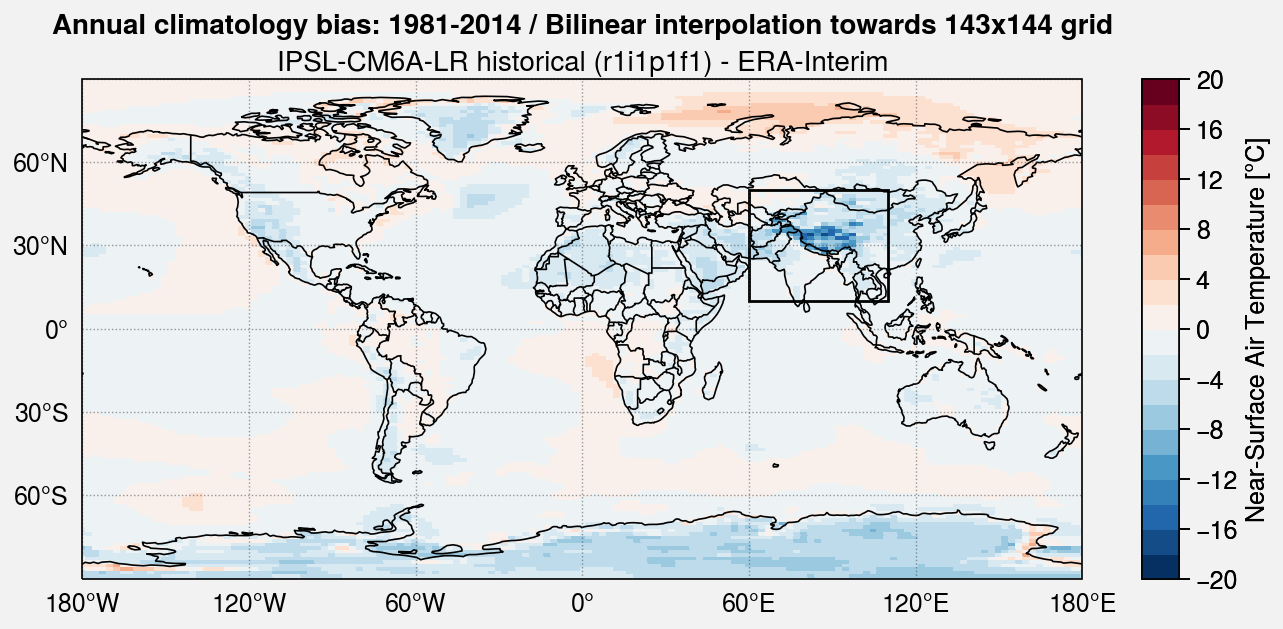

In [9]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

dx=2.5
dy=1.2676

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=5)

m = axs[0].pcolormesh(tas_bias, cmap='RdBu_r', levels=plot.arange(-20,20,2))
axs[0].format(title='IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim')

f.colorbar(m, label='Near-Surface Air Temperature [°C]')


# Add box   
axs[0].add_patch(mpatches.Rectangle(
    xy=[lonlim[0], latlim[0]], width=lonlim[1]-lonlim[0], height=latlim[1]-latlim[0],
    transform=ccrs.PlateCarree(), fill=False
))


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=60, latlines=30, abc=False
)

var = 'ta'
# f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias_global.png')
# f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias_global.pdf')

# Load surface pressure for masking ERA-Interim
http://clipc-services.ceda.ac.uk/dreq/u/8c9504d28596e05586c8e193082ac617.html

In [10]:
realization = 'r1i1p1f1'
var = 'ps'
table = 'Amon'

# Load historical
ps = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]

# ERA-Interim
ps_era = xr.open_mfdataset(
    "/data/mlalande/ERAI/sp/sp_ERAI_*.nc",
    combine='by_coords', parallel=True
).sp.sel(time=period).load()

In [11]:
ps_era_regrid = regridder(ps_era)

# Get the minimum pressure (finally not used)
ps_min = ps.min('time')
ps_era_regrid_min = ps_era_regrid.min('time')

# Load Air Temperature

In [12]:
var ='ta'

ta = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
).sel(time=period)[var].load()-273.15

ta_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/ta.*.apmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).ta.sel(time=period).load()-273.15

## Regrid horizontal

In [13]:
# Regrid horizontal
ta_era_regrid = regridder(ta_era)

## Mask vertical values > ps

In [14]:
ta_era_regrid_masked = ta_era_regrid.where(ta_era_regrid.level <= ps_era_regrid/100)

## Regrid vertical

In [15]:
ta_era_regrid_masked_v = ta_era_regrid_masked.interp(level=(ta.plev.values/100), method='linear')

## Compute climatologie

In [16]:
ta_clim = ta.mean('time', skipna=False).load()
ta_era_regrid_masked_clim = ta_era_regrid_masked.mean('time', skipna=False).load()
ta_era_regrid_masked_v_clim = ta_era_regrid_masked_v.mean('time', skipna=False).load()

ta_bias = ta_clim-ta_era_regrid_masked_v_clim.values

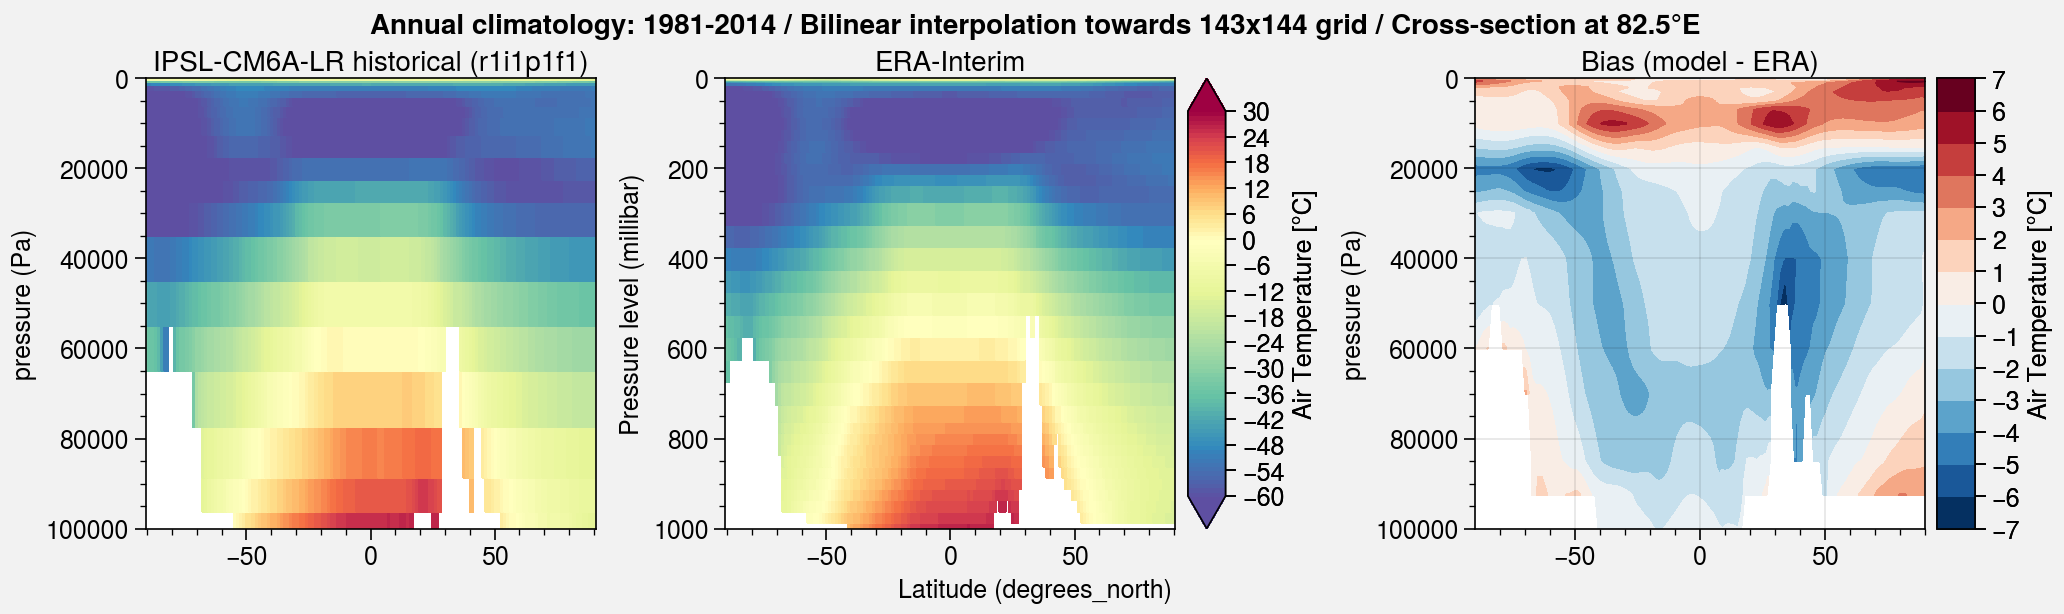

In [17]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lon=82.5), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon_82_5_ta_pcolormesh_global.png')
# f.save('img/ta/slice_lon_82_5_ta_pcolormesh_global.pdf')

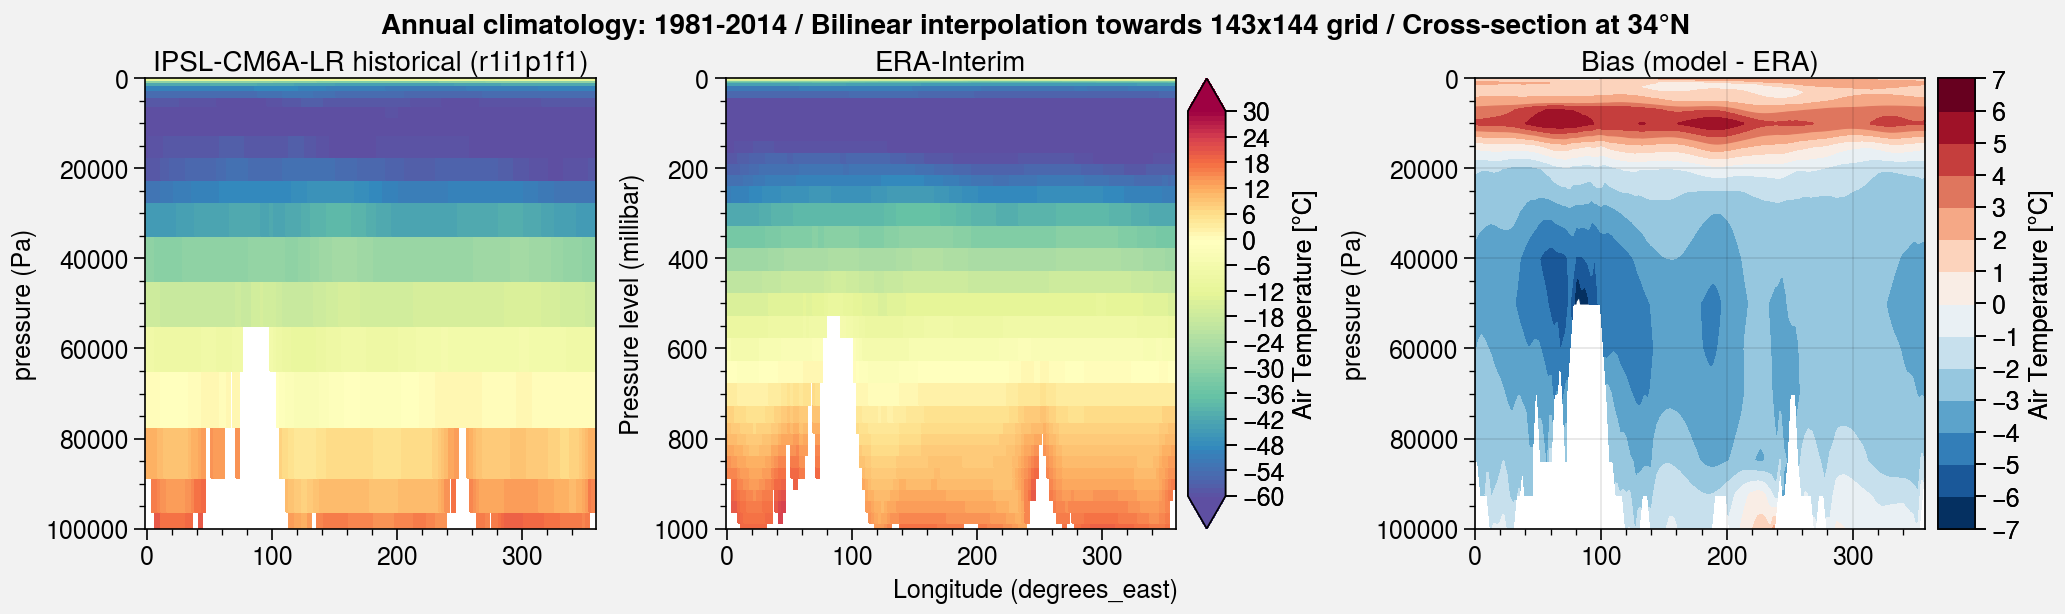

In [18]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lat=34.225353), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 34°N"
)

# f.save('img/ta/slice_lat_34_ta_pcolormesh_global.png')
# f.save('img/ta/slice_lat_34_ta_pcolormesh_global.pdf')

# Zonal and meridional mean global / HM / global-HM

In [30]:
ta_bias.sel(lon=slice(lonlim[0],lonlim[1]))

<xarray.DataArray 'ta' (plev: 19, lat: 143, lon: 21)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 2.78185796e+00,  2.78290380e+00,  2.78594254e+00, ...,
          2.73495641e+00,  2.73207728e+00,  2.72478243e+00],
        [ 2.80820242e+00,  2.80357872e+00,  2.80009933e+00, ...,
          2.72541695e+00,  2.72183489e+00,  2.72076086e+00],
        [ 2.79210147e+00,  2.79210147e+00,  2.79210147e+00, ...,
          2.79210147e+00,  2.79210147e+00,  2.79210147e+00]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 1.74039083e+00,  1.74279395e+00,  1.74160307e+00, ...,
          1.73840140e+00,  1.73845166e+00,  1.74002769e+00],
        [ 1.78787938e+00,  1.78918032e+00,  1.78737698e+00, ...,
          1.76331535e+00,  1.76050039e+00,  1.75936552e+00],
        [ 1.81742305e+00,  1.81742305e+00,  1.81742305e+00, ...,
          1.81742305e+00,  1.81742305e+00,  1.81742305e+00]],

       ...,

       [[ 3.51897307e+00,  3.51897307e+00,  3.51897307e+00, ...,
          3.51897307e+00,  3.51897307e+00,  3.51897307e+00],
        [ 3.46848713e+00,  3.46341455e+00,  3.45843550e+00, ...,
          3.39453296e+00,  3.39198182e+00,  3.38954664e+00],
        [ 3.44654342e+00,  3.43630850e+00,  3.42614202e+00, ...,
          3.29611664e+00,  3.29101551e+00,  3.28628213e+00],
        ...,
        [ 5.83026215e+00,  5.81923751e+00,  5.80769160e+00, ...,
          5.57468590e+00,  5.55872155e+00,  5.54279457e+00],
        [ 5.73167008e+00,  5.72617349e+00,  5.72046516e+00, ...,
          5.60740389e+00,  5.59976843e+00,  5.59215952e+00],
        [ 5.76191696e+00,  5.76191696e+00,  5.76191696e+00, ...,
          5.76191696e+00,  5.76191696e+00,  5.76191696e+00]],

       [[ 4.27632107e+00,  4.27632107e+00,  4.27632107e+00, ...,
          4.27632107e+00,  4.27632107e+00,  4.27632107e+00],
        [ 4.17221242e+00,  4.16880542e+00,  4.16563475e+00, ...,
          4.14312708e+00,  4.14361019e+00,  4.14431309e+00],
        [ 4.05808544e+00,  4.05118746e+00,  4.04462554e+00, ...,
          3.99795886e+00,  3.99905620e+00,  4.00059300e+00],
        ...,
        [ 6.44333870e+00,  6.41869334e+00,  6.39341456e+00, ...,
          5.94385961e+00,  5.91578936e+00,  5.88811701e+00],
        [ 6.30140917e+00,  6.28905308e+00,  6.27634134e+00, ...,
          6.05379155e+00,  6.03998591e+00,  6.02630062e+00],
        [ 6.04080107e+00,  6.04080107e+00,  6.04080107e+00, ...,
          6.04080107e+00,  6.04080107e+00,  6.04080107e+00]],

       [[ 2.58539069e-01,  2.58539069e-01,  2.58539069e-01, ...,
          2.5

In [19]:
lonlim

(60, 110)

In [20]:
ta_bias.sel(lon=slice(lonlim[0],lonlim[1]))

<xarray.DataArray 'ta' (plev: 19, lat: 143, lon: 21)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 2.78185796e+00,  2.78290380e+00,  2.78594254e+00, ...,
          2.73495641e+00,  2.73207728e+00,  2.72478243e+00],
        [ 2.80820242e+00,  2.80357872e+00,  2.80009933e+00, ...,
          2.72541695e+00,  2.72183489e+00,  2.72076086e+00],
        [ 2.79210147e+00,  2.79210147e+00,  2.79210147e+00, ...,
          2.79210147e+00,  2.79210147e+00,  2.79210147e+00]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 1.74039083e+00,  1.74279395e+00,  1.74160307e+00, ...,
          1.73840140e+00,  1.73845166e+00,  1.74002769e+00],
        [ 1.78787938e+00,  1.78918032e+00,  1.78737698e+00, ...,
          1.76331535e+00,  1.76050039e+00,  1.75936552e+00],
        [ 1.81742305e+00,  1.81742305e+00,  1.81742305e+00, ...,
          1.81742305e+00,  1.81742305e+00,  1.81742305e+00]],

       ...,

       [[ 3.51897307e+00,  3.51897307e+00,  3.51897307e+00, ...,
          3.51897307e+00,  3.51897307e+00,  3.51897307e+00],
        [ 3.46848713e+00,  3.46341455e+00,  3.45843550e+00, ...,
          3.39453296e+00,  3.39198182e+00,  3.38954664e+00],
        [ 3.44654342e+00,  3.43630850e+00,  3.42614202e+00, ...,
          3.29611664e+00,  3.29101551e+00,  3.28628213e+00],
        ...,
        [ 5.83026215e+00,  5.81923751e+00,  5.80769160e+00, ...,
          5.57468590e+00,  5.55872155e+00,  5.54279457e+00],
        [ 5.73167008e+00,  5.72617349e+00,  5.72046516e+00, ...,
          5.60740389e+00,  5.59976843e+00,  5.59215952e+00],
        [ 5.76191696e+00,  5.76191696e+00,  5.76191696e+00, ...,
          5.76191696e+00,  5.76191696e+00,  5.76191696e+00]],

       [[ 4.27632107e+00,  4.27632107e+00,  4.27632107e+00, ...,
          4.27632107e+00,  4.27632107e+00,  4.27632107e+00],
        [ 4.17221242e+00,  4.16880542e+00,  4.16563475e+00, ...,
          4.14312708e+00,  4.14361019e+00,  4.14431309e+00],
        [ 4.05808544e+00,  4.05118746e+00,  4.04462554e+00, ...,
          3.99795886e+00,  3.99905620e+00,  4.00059300e+00],
        ...,
        [ 6.44333870e+00,  6.41869334e+00,  6.39341456e+00, ...,
          5.94385961e+00,  5.91578936e+00,  5.88811701e+00],
        [ 6.30140917e+00,  6.28905308e+00,  6.27634134e+00, ...,
          6.05379155e+00,  6.03998591e+00,  6.02630062e+00],
        [ 6.04080107e+00,  6.04080107e+00,  6.04080107e+00, ...,
          6.04080107e+00,  6.04080107e+00,  6.04080107e+00]],

       [[ 2.58539069e-01,  2.58539069e-01,  2.58539069e-01, ...,
          2.5

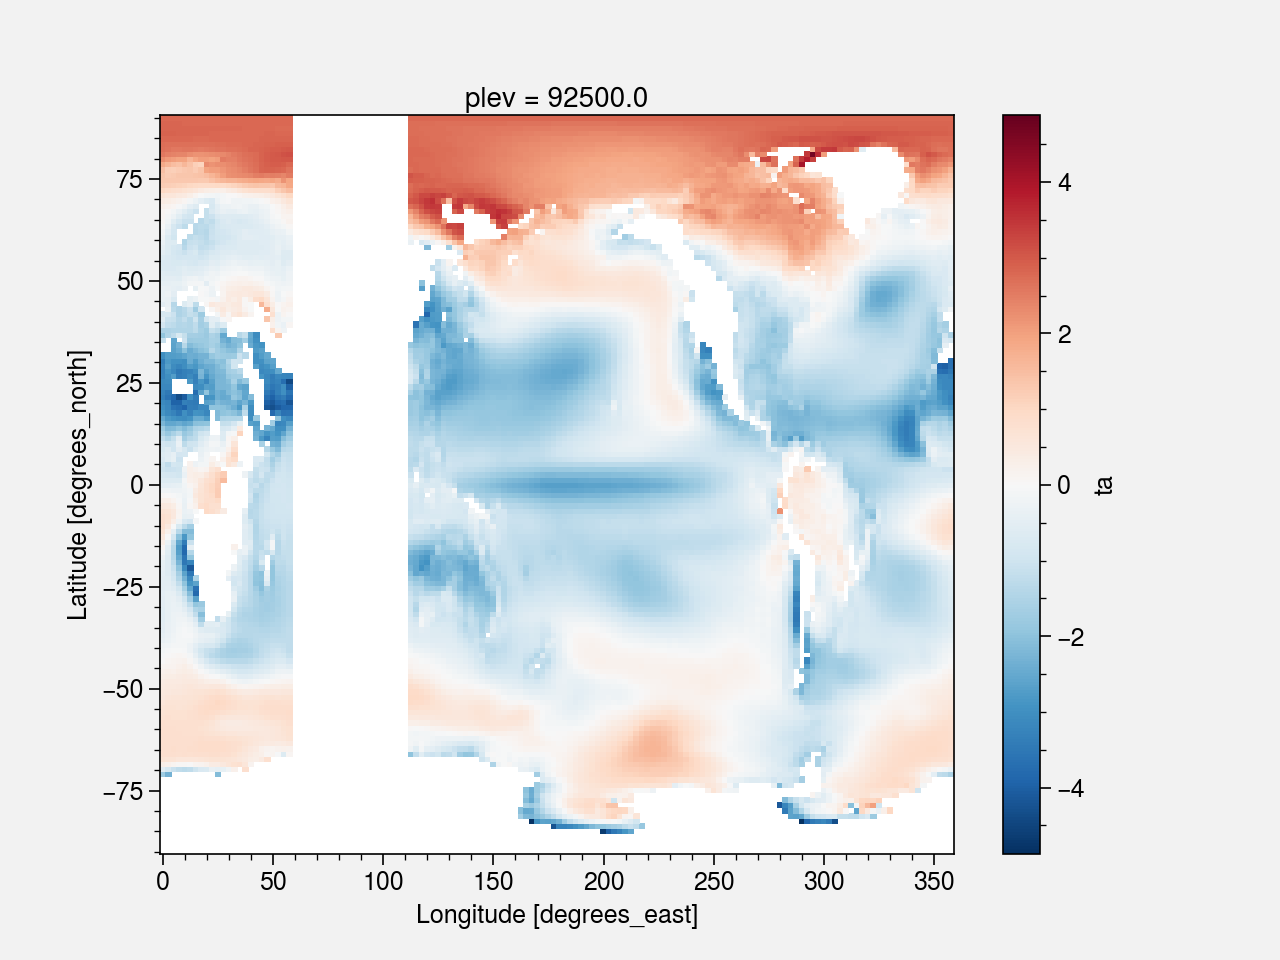

In [36]:
ta_bias.where((ta_bias.lon < 60) | (ta_bias.lon > 110), drop=False)[1].plot()

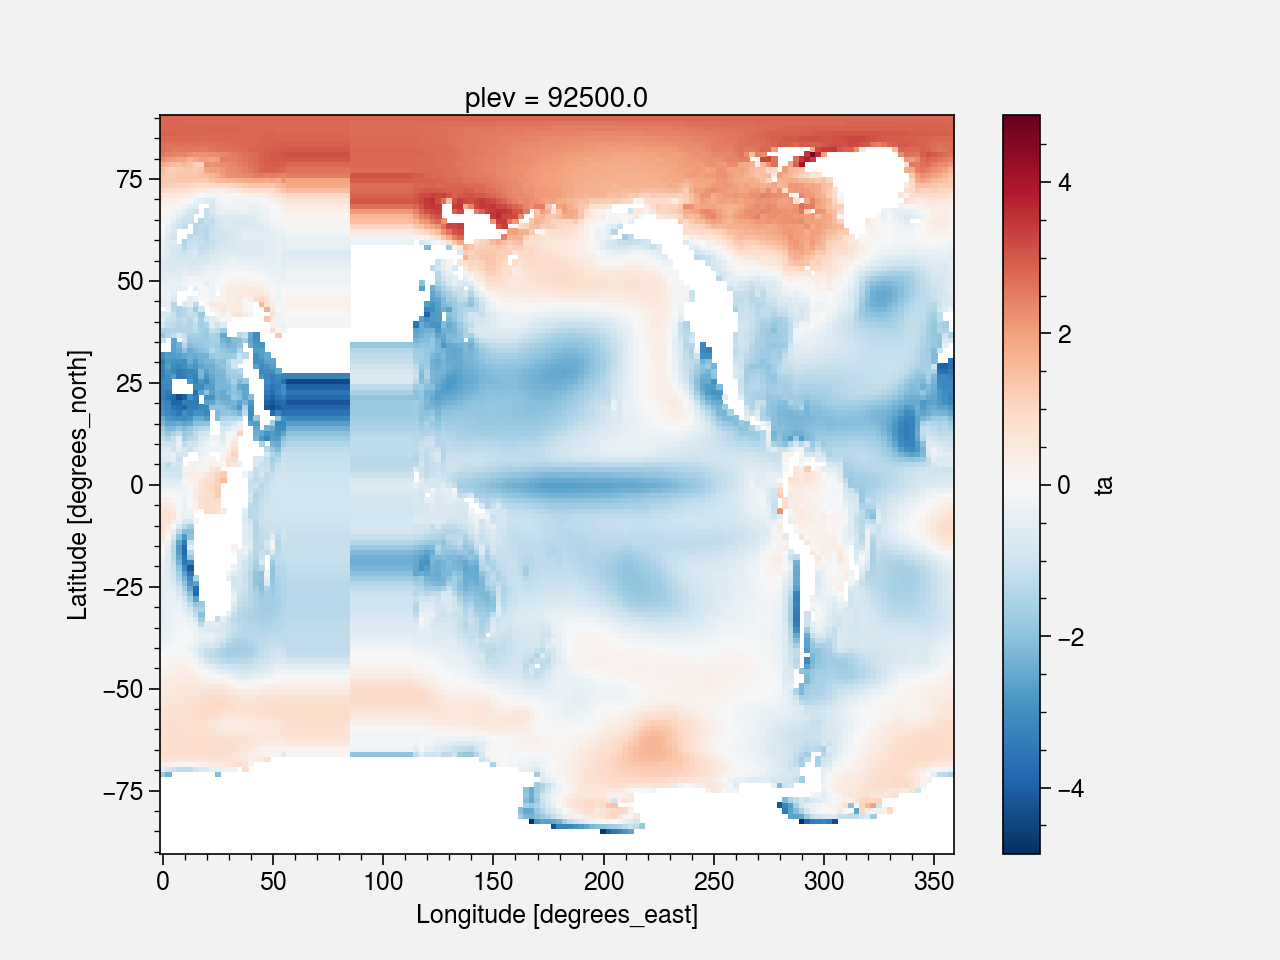

In [35]:
ta_bias.where((ta_bias.lon < 60) | (ta_bias.lon > 110), drop=True)[1].plot()

In [37]:
ta_bias.where((ta_bias.lon < 60) | (ta_bias.lon > 110), drop=True)

<xarray.DataArray 'ta' (plev: 19, lat: 143, lon: 123)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [2.85395726, 2.84671984, 2.83931778, ..., 2.86927517,
         2.86499789, 2.85882449],
        [2.83467154, 2.83019956, 2.82587893, ..., 2.84250603,
         2.83924315, 2.83722329],
        [2.79210147, 2.79210147, 2.79210147, ..., 2.79210147,
         2.79210147, 2.79210147]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [1.79600981, 1.79079155, 1.78196091, ..., 1.81787895,
         1.81056298, 1.80204466],
        [1.8248854 , 1.82053298, 1.81654826, ..., 1.83507469,
         1.8300434 , 1.82656808],
        [1.81742305, 1.81742305, 1.81742305, ..., 1.81742305,
         1.81742305, 1.81742305]],

       ...,

       [[3.51897307, 3.51897307, 3.51897307, ..., 3.51897307,
         3.51897307, 3.51897307],
        [3.5791143 , 3.57579266, 3.57219004, ..., 3.58803925,
         3.58516539, 3.582242  ],
        [3.66831949, 3.66184778, 3.654914  , ..., 3.6851404 ,
         3.67992031, 3.67437389],
        ...,
        [5.91433208, 5.9179059 , 5.92091668, ..., 5.90026239,
         5.90548907, 5.91020204],
        [5.77683922, 5.77841832, 5.77972416, ..., 5.77017019,
         5.77262921, 5.77492743],
        [5.76191696, 5.76191696, 5.76191696, ..., 5.76191696,
         5.76191696, 5.76191696]],

       [[4.27632107, 4.27632107, 4.27632107, ..., 4.27632107,
         4.27632107, 4.27632107],
        [4.28511854, 4.2800011 , 4.27485677, ..., 4.30007598,
         4.29513755, 4.29012676],
        [4.28841363, 4.27829452, 4.26802339, ..., 4.31765259,
         4.30809555, 4.29833801],
        ...,
        [6.77392646, 6.77191017, 6.76882289, ..., 6.77358342,
         6.77478717, 6.77490177],
        [6.4697217 , 6.46875981, 6.46715629, ..., 6.46914717,
         6.46990206, 6.47007409],
        [6.04080107, 6.04080107, 6.04080107, ..., 6.04080107,
         6.04080107, 6.04080107]],

       [[0.25853907, 0.25853907, 0.25853907, ..., 0.25853907,
         0.25853907, 0.25853907],
        [0.22627922, 0.22081191, 0.21548911, ..., 0.24341917,
         0.2375957 , 0.23191529],
        [0.14962973, 0.13961401, 0.12980697, ..., 0.18051981,
         0.17011902, 0.15982383],
        ...,
        [1.42817372, 1.40876294, 1.38832371, ..., 1.48015879,
         1.46392336, 1.44660775],
        [1.14749985, 1.13716054, 1.12637593, ..., 1.17523296,
         1.1665905 , 1.15739665],
        [0.68530642, 0.68530642, 0.68530642, ..., 0.68530642,
         0.68530642, 0.68530642]]])
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * plev     (plev) float32 100000.0 92500.0 85000.0 ... 1000.0 500.0 100.0

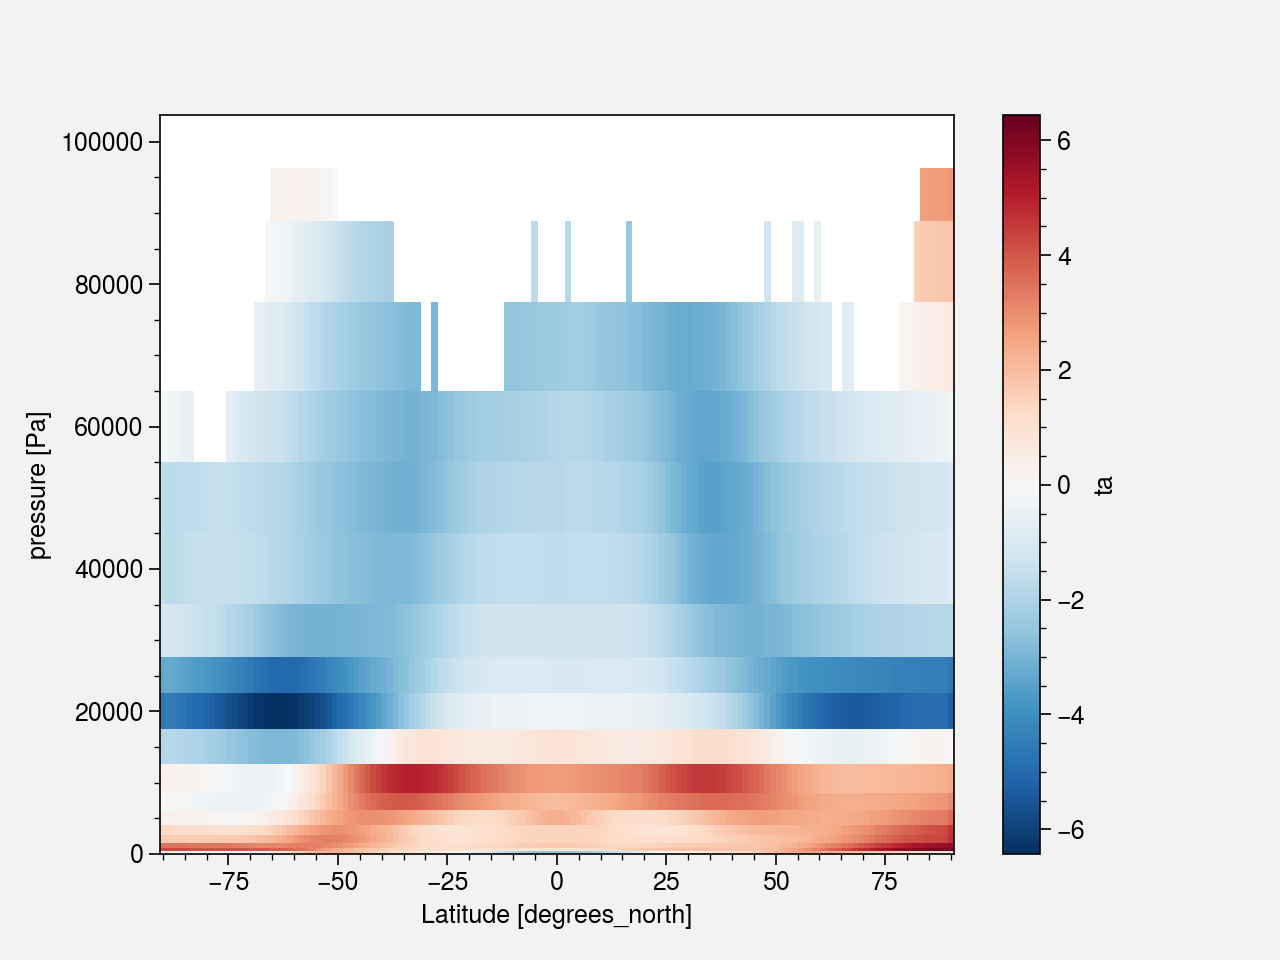

In [31]:
ta_bias.where((ta_bias.lon < 60) | (ta_bias.lon > 110), drop=True).mean('lon', skipna=False).plot()

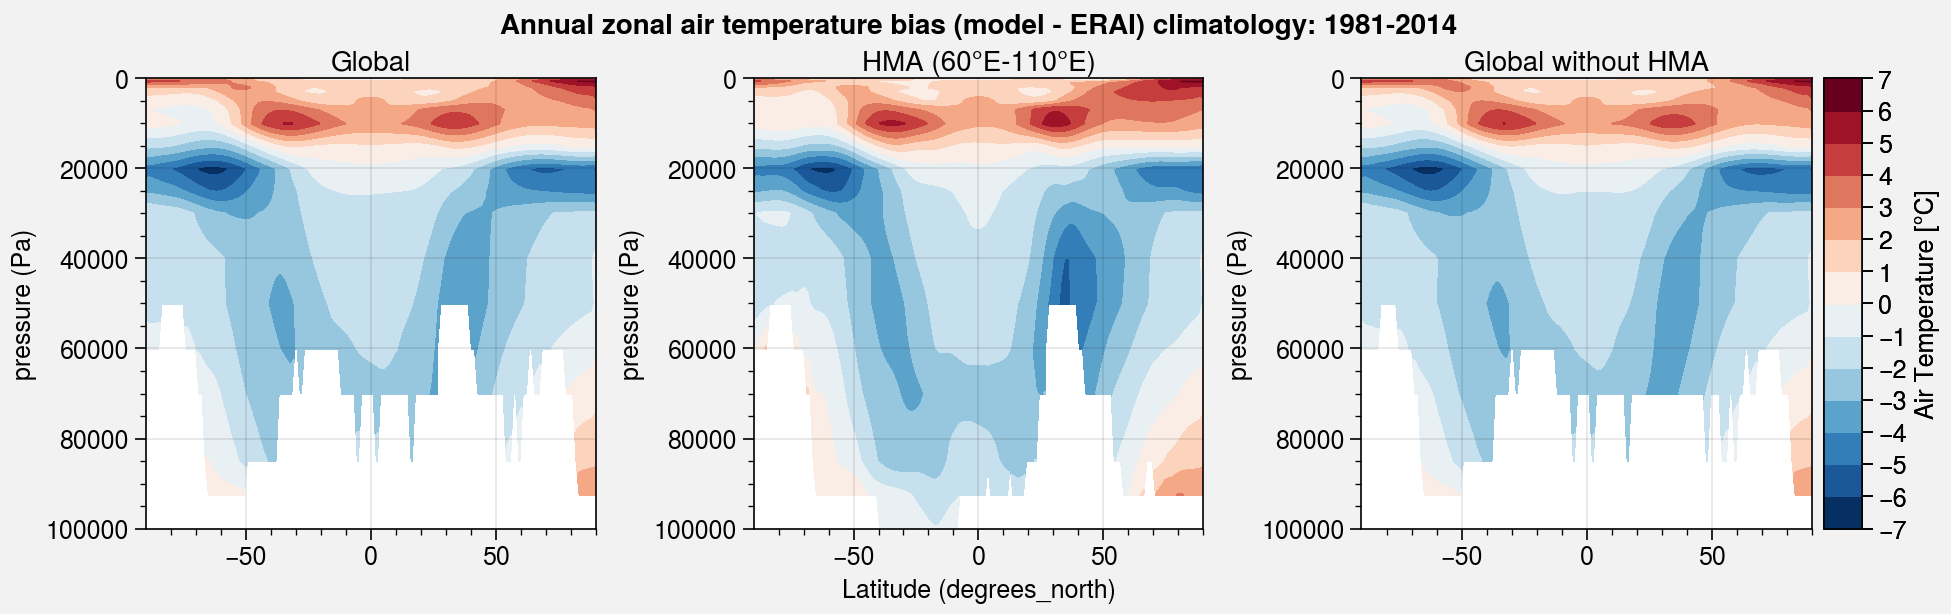

In [38]:
#Check colorbars 
levels=plot.arange(-7,7,1)
extend='both'
cmap='BuRd'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
axs[0].contourf(ta_bias.mean('lon', skipna=False), cmap=cmap, levels=levels)
axs[0].format(ylim=(100000,0), title='Global')

# ERA-Interim
axs[1].contourf(ta_bias.sel(lon=slice(lonlim[0],lonlim[1])).mean('lon', skipna=False), cmap=cmap, levels=levels)
axs[1].format(ylim=(100000,0), title='HMA (60°E-110°E)')

# Bias
m2 = axs[2].contourf(ta_bias.where((ta_bias.lon < 60) | (ta_bias.lon > 110), drop=True).mean('lon', skipna=False), cmap=cmap, levels=levels)
axs[2].format(ylim=(100000,0), title='Global without HMA')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual zonal air temperature bias (model - ERAI) climatology: 1981-2014"
)

# f.save('img/ta/zonal_ta_global_HMA.png')
# f.save('img/ta/zonal_ta_global_HMA.pdf')